In [3]:
%load_ext autoreload
%autoreload 2
import sys 
from FR3Py.robot.interface import FR3Real
robot = FR3Real(robot_id='fr3')

Exception in thread Thread-6 (LCMThreadFunc):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/opt/conda/lib/python3.11/threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)
  File "/FR3Py/FR3Py/robot/interface.py", line 53, in LCMThreadFunc
    self.lc.handle()
  File "/FR3Py/FR3Py/robot/interface.py", line 63, in update
    msg = fr3_state.decode(data)
          ^^^^^^^^^^^^^^^^^^^^^^
  File "/FR3Py/FR3Py/lcm_msgs/fr3_states/fr3_state.py", line 44, in decode
    raise ValueError("Decode error")
ValueError: Decode error


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Interface Running...


In [4]:
robot.getJointStates()

{'q': array([-3.85171001e-05, -7.84787350e-01,  2.53298197e-03, -2.39357691e+00,
        -9.48573147e-04,  1.56909565e+00,  7.86517693e-01]),
 'dq': array([-0.00018481, -0.0002845 , -0.00055567,  0.00122656,  0.00037558,
         0.0008519 ,  0.00019303]),
 'T': array([-8.63957033e-03, -4.27423239e+00, -8.74777198e-01,  2.30957375e+01,
         1.04936445e+00,  2.22104621e+00, -6.36040866e-02])}

### Preparation

In [5]:
import numpy as np
from FR3Py.robot.model_collision_avoidance import PinocchioModel
import time

pin_robot = PinocchioModel()
joint_lb = np.array([-2.3093, -1.5133, -2.4937, -2.7478, -2.48, 0.8521, -2.6895])
joint_ub = np.array([2.3093, 1.5133, 2.4937, -0.4461, 2.48, 4.2094, 2.6895])
torque_lb = np.array([-87, -87, -87, -87, -12, -12, -12])
torque_ub = np.array([87, 87, 87, 87, 12, 12, 12])
joint_acc_lb = np.array([-10, -10, -10, -10, -10, -10, -10])
joint_acc_ub = np.array([10, 10, 10, 10, 10, 10, 10])
v_EE_lb = np.array([-0.1, -0.1, -0.1])
v_EE_ub = np.array([0.1, 0.1, 0.1])
static_friction = np.array([0.8, 1.1, 0.5, 1.7, 1.8, 1.0, 0.6])

n_joints = 7
n_controls = 7
q_bar = 0.5*(joint_ub + joint_lb)


In [6]:
from cores.utils.bounding_shape_coef_mj import BoundingShapeCoef
from cores.obstacle_collections.polytope_collection import PolytopeCollection
import scalingFunctionsHelperPy as sfh
import HOCBFHelperPy as hh
from scipy.spatial.transform import Rotation
import multiprocessing
from cores.utils.trajectory_utils import PositionTrapezoidalTrajectory, OrientationTrapezoidalTrajectory
from liegroups import SO3
from cores.utils.proxsuite_utils import init_proxsuite_qp
from cores.utils.rotation_utils import get_quat_from_rot_matrix

/liegroups/liegroups/numpy/so3.py:81: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if ordering is 'xyzw':
/liegroups/liegroups/numpy/so3.py:83: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif ordering is 'wxyz':
/liegroups/liegroups/numpy/so3.py:298: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if ordering is 'xyzw':
/liegroups/liegroups/numpy/so3.py:300: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif ordering is 'wxyz':
/liegroups/liegroups/numpy/so3.py:387: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if ordering is 'xyzw':
/liegroups/liegroups/numpy/so3.py:389: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif ordering is 'wxyz':


In [5]:
# Obstacle parameters
obstacle_config = {
    "obs1":{
        "type": "polytope3d",
        "vertices": [[0.226, 0.293, 0.28], [0.234, 0.287, 0.28], [0.416, 0.543, 0.28], [0.424, 0.537, 0.28], [0.226, 0.293, 0.0], [0.234, 0.287, 0.0], [0.416, 0.543, 0.0], [0.424, 0.537, 0.0]],
        "pos": [0.0, 0.0, 0.0],
        "quat": [0.0, 0.0, 0.0, 1.0]
    },

    "obs2":{
        "type": "polytope3d",
        "vertices": [[0.417, 0.536, 0.28], [0.423, 0.544, 0.28], [0.047, 0.826, 0.28], [0.053, 0.834, 0.28], [0.417, 0.536, 0.0], [0.423, 0.544, 0.0], [0.047, 0.826, 0.0], [0.053, 0.834, 0.0]],
        "pos": [0.0, 0.0, 0.0],
        "quat": [0.0, 0.0, 0.0, 1.0]
    },

    "obs3":{
        "type": "polytope3d",
        "vertices": [[0.054, 0.827, 0.28], [0.046, 0.833, 0.28], [-0.136, 0.577, 0.28], [-0.144, 0.583, 0.28], [0.054, 0.827, 0.0], [0.046, 0.833, 0.0], [-0.136, 0.577, 0.0], [-0.144, 0.583, 0.0]],
        "pos": [0.0, 0.0, 0.0],
        "quat": [0.0, 0.0, 0.0, 1.0]
    },

    "obs4":{
        "type": "polytope3d",
        "vertices": [[-0.137, 0.584, 0.28], [-0.143, 0.576, 0.28], [0.233, 0.294, 0.28], [0.227, 0.286, 0.28], [-0.137, 0.584, 0.0], [-0.143, 0.576, 0.0], [0.233, 0.294, 0.0], [0.227, 0.286, 0.0]],
        "pos": [0.0, 0.0, 0.0],
        "quat": [0.0, 0.0, 0.0, 1.0]
    }

}

In [6]:
# Load the bounding shape coefficients
BB_coefs = BoundingShapeCoef()
selected_BBs = ["HAND_BB", "LINK7_BB", "LINK6_BB"]
n_selected_BBs = len(selected_BBs)

# Obstacle
n_polytope = len(obstacle_config)
obs_col = PolytopeCollection(3, n_polytope, obstacle_config)

# CBF parameters
obstacle_kappa = 80

robot_SFs = []
for (i, bb_key) in enumerate(selected_BBs):
    ellipsoid_quadratic_coef = BB_coefs.coefs[bb_key]
    SF_rob = sfh.Ellipsoid3d(True, ellipsoid_quadratic_coef, np.zeros(3))
    robot_SFs.append(SF_rob)

polytope_SFs = []
for (i, obs_key) in enumerate(obs_col.face_equations.keys()):
    A_obs_np = obs_col.face_equations[obs_key]["A"]
    b_obs_np = obs_col.face_equations[obs_key]["b"]
    obs_kappa = obstacle_kappa
    SF_obs = sfh.LogSumExp3d(False, A_obs_np, b_obs_np, obs_kappa)
    polytope_SFs.append(SF_obs)
    
hyperplane_SFs = []
SF_hyperplane = sfh.Hyperplane3d(False, np.array([0,0,1]), 0.0+1.0)
hyperplane_SFs.append(SF_hyperplane)

# Create the problem collection
n_threads = max(multiprocessing.cpu_count() -1, 1)
probs = hh.Problem3dCollection(n_threads)
for i in range(len(selected_BBs)):
    SF_rob = robot_SFs[i]
    frame_id = i
    for (j, obs_key) in enumerate(obs_col.face_equations.keys()):
        SF_obs = polytope_SFs[j]
        vertices = obs_col.face_equations[obs_key]["vertices_in_world"]
        prob = hh.EllipsoidAndLogSumExp3dPrb(SF_rob, SF_obs, vertices)
        probs.addProblem(prob, frame_id)

    for j in range(len(hyperplane_SFs)):
        SF_obs = hyperplane_SFs[j]
        prob = hh.EllipsoidAndHyperplane3dPrb(SF_rob, SF_obs)
        probs.addProblem(prob, frame_id)


/workspaces/HOCBF-FR3-Experiments/cores/obstacle_collections/polytope_collection.py:13: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(dist_matrix, method='single')


In [7]:
# Rotate link 1 to reach preparation configuration
T = 6
# q_d = np.array([np.pi/3+0.2, -np.pi/4, 0, -np.pi/4*3, 0, np.pi/2 + 0.2, np.pi/4])
q_d = np.array([np.pi/3, -np.pi/4, 0, -np.pi/4*3, 0, np.pi/2 , np.pi/4])


Kp_joint = np.diag([1, 1, 1, 1, 4, 2, 1])*1.5e2
Kd_joint = np.diag([2, 2, 2, 2, 2, 2, 2])*1e2
t_start = time.time()
while time.time() - t_start < T:
    robot_info = robot.getJointStates()
    q = robot_info['q'] # shape (7,)
    dq = robot_info['dq'] # shape (7,)

    q_pin = 0.025*np.ones(9)
    dq_pin = np.zeros(9)
    q_pin[0:n_joints] = q # shape (9,)
    dq_pin[0:n_joints] = dq # shape (9,)

    pin_info = pin_robot.getInfo(q_pin, dq_pin)
    P_EE = pin_info["P_EE"]
    R_EE = pin_info["R_EE"]
    M = pin_info["M"][0:n_joints,0:n_joints] + 0.15*np.eye(n_joints) # shape (7,7)
    nle = pin_info["nle"][0:n_joints]  # shape (7,)
    G = pin_info["G"][0:n_joints]  # shape (7,)

    W = np.diag(1.0/(joint_ub-joint_lb))
    eq = W @ (q - q_d)
    deq = W @ dq
    ddq_nominal = - Kd_joint @ deq - Kp_joint @ eq

    ddq = ddq_nominal

    tau = M @ ddq + nle - G + static_friction * np.tanh(dq)

    tau = np.clip(tau, torque_lb, torque_ub)
    robot.setCommands(tau)

robot.setCommands(np.zeros_like(tau))


### Generate the trajectory

In [8]:

robot_info = robot.getJointStates()
q = robot_info['q'] # shape (7,)
dq = robot_info['dq'] # shape (7,)

q_pin = 0.025*np.ones(9)
dq_pin = np.zeros(9)
q_pin[0:n_joints] = q # shape (9,)
dq_pin[0:n_joints] = dq # shape (9,)

pin_info = pin_robot.getInfo(q_pin, dq_pin)
P_EE = pin_info["P_EE"]
R_EE = pin_info["R_EE"]

t_1 = 10
t_2 = 15
t_3 = 25
t_final = 35

# Translational trajectory4
P_EE_0 = P_EE.copy()
# P_EE_1 = np.array([0.16, 0.62, 0.04])
P_EE_1 = np.array([0.18, 0.61, 0.10])
# P_EE_2 = np.array([0.45, 0.25, 0.01])
P_EE_2 = np.array([0.50, 0.25, 0.08])

via_points = np.array([P_EE_0, P_EE_1, P_EE_1, P_EE_2, P_EE_2])
# via_points = np.array([P_EE_0, P_EE_0, P_EE_0, P_EE_0])

target_time = np.array([0, t_1, t_2, t_3, t_final])
Ts = 0.01
traj_position = PositionTrapezoidalTrajectory(via_points, target_time, T_antp=0.2, Ts=Ts)

# Rotational trajectory
R_EE_0  = R_EE.copy()

roll = np.pi
pitch = 0
yaw = np.pi/3
R_EE_1 = Rotation.from_euler('xyz', [roll, pitch, yaw]).as_matrix()

roll = np.pi
pitch = 0
yaw = np.pi/6
R_EE_2 = Rotation.from_euler('xyz', [roll, pitch, yaw]).as_matrix()

orientations = np.array([R_EE_0, R_EE_1, R_EE_1, R_EE_2, R_EE_2])
# orientations = np.array([R_EE_0, R_EE_0, R_EE_0, R_EE_0])
target_time = np.array([0, t_1, t_2, t_3, t_final])
traj_orientation = OrientationTrapezoidalTrajectory(orientations, target_time, Ts=Ts)

### Collision avoidance without circulation

In [11]:
# Define proxuite problem
n_obstacle = n_polytope + 1
n_CBF = n_selected_BBs*n_obstacle
n_controls = 7
n_in = n_controls + n_CBF + 3
cbf_qp = init_proxsuite_qp(n_v=n_controls, n_eq=0, n_in=n_in)

In [12]:
T = 35

alpha0 = 1.03
gamma1 = 20
gamma2 = 20
compensation = 0

K_p_pos = np.diag([100,100,100])*0.9
K_d_pos = np.diag([50,50,50])*0.5

K_p_rot = np.diag([200,200,200])*1.8
K_d_rot = np.diag([100,100,100])*0.4

Kp_joint = 20*np.diag([1, 1, 1, 1, 1, 1, 1])
Kd_joint = 10*np.diag([1, 1, 1, 1, 1, 1, 1])

ddq_list = []
tau_list = []
all_h_list = []

t_start = time.time()
while time.time() - t_start < T:
    t = time.time() - t_start
    traj_pos, traj_pos_dt, traj_pos_dtdt = traj_position.get_traj_and_ders(t)
    traj_ori, traj_ori_dt, traj_ori_dtdt = traj_orientation.get_traj_and_ders(t)

    robot_info = robot.getJointStates()
    q = robot_info['q'] # shape (7,)
    dq = robot_info['dq'] # shape (7,)

    q_pin = 0.025*np.ones(9)
    dq_pin = np.zeros(9)
    q_pin[0:n_joints] = q # shape (9,)
    dq_pin[0:n_joints] = dq # shape (9,)

    pin_info = pin_robot.getInfo(q_pin, dq_pin)

    P_EE = pin_info["P_EE"]
    R_EE = pin_info["R_EE"]
    J_EE = pin_info["J_EE"][:,0:n_joints] # shape (6,7)
    dJdq_EE = pin_info["dJdq_EE"] # shape (6,)
    v_EE = J_EE @ dq # shape (6,)
    M = pin_info["M"][0:n_joints,0:n_joints] + 0.15*np.eye(n_joints) # shape (7,7)
    nle = pin_info["nle"][0:n_joints]  # shape (7,)
    G = pin_info["G"][0:n_joints]  # shape (7,)

    # Primary obejctive: tracking control
    e_pos = P_EE - traj_pos # shape (3,)
    e_pos_dt = v_EE[:3] - traj_pos_dt # shape (3,)
    v_dt = traj_pos_dtdt - K_p_pos @ e_pos - K_d_pos @ e_pos_dt

    e_rot = SO3(R_EE @ traj_ori.T).log() # shape (3,)
    e_rot_dt = v_EE[3:] - traj_ori_dt # shape (3,)
    omega_dt = traj_ori_dtdt -K_p_rot @ e_rot - K_d_rot @ e_rot_dt

    v_EE_dt_desired = np.concatenate([v_dt, omega_dt])
    S = J_EE
    S_pinv = S.T @ np.linalg.pinv(S @ S.T + 0.01* np.eye(S.shape[0]))
    S_null = (np.eye(len(q)) - S_pinv @ S)
    ddq_task = S_pinv @ (v_EE_dt_desired - dJdq_EE)

    # Secondary objective: encourage the joints to remain close to the initial configuration
    W = np.diag(1.0/(joint_ub-joint_lb))
    q_bar = 1/2*(joint_ub+joint_lb)
    e_joint = W @ (q - q_bar)
    e_joint_dot = W @ dq
    ddq_nominal = ddq_task + S_null @ (- Kp_joint @ e_joint - Kd_joint @ e_joint_dot)

    # CBF
    C = np.zeros([n_in, n_controls])
    lb = np.zeros(n_in)
    ub = np.zeros(n_in)
    CBF_tmp = np.zeros(n_CBF)
    phi1_tmp = np.zeros(n_CBF)
    phi2_tmp = np.zeros(n_CBF)

    all_P_np = np.zeros([n_selected_BBs, 3])
    all_quat_np = np.zeros([n_selected_BBs, 4])
    all_J_np = np.zeros([n_selected_BBs, 6, 7])
    all_dJdq_np = np.zeros([n_selected_BBs, 6])

    for (ii, bb_key) in enumerate(selected_BBs):
        all_P_np[ii, :] = pin_info["P_"+bb_key]
        all_J_np[ii, :, :] = pin_info["J_"+bb_key][:,:7]
        all_quat_np[ii, :] = get_quat_from_rot_matrix(pin_info["R_"+bb_key])
        all_dJdq_np[ii, :] = pin_info["dJdq_"+bb_key][:7]

    all_h_np, _, _, all_phi1_np, all_actuation_np, all_lb_np, all_ub_np = \
        probs.getCBFConstraints(dq, all_P_np, all_quat_np, all_J_np, all_dJdq_np, alpha0, gamma1, gamma2, compensation)
    
    # CBF-QP constraints
    C[0:n_CBF,:] = all_actuation_np
    lb[0:n_CBF] = all_lb_np
    ub[0:n_CBF] = all_ub_np
    CBF_tmp = all_h_np
    phi1_tmp = all_phi1_np

    print(np.min(CBF_tmp))
    g = -ddq_nominal

    C[n_CBF:n_CBF+n_controls,:] = np.eye(n_controls)
    lb[n_CBF:n_CBF+n_controls] = joint_acc_lb[:7]
    ub[n_CBF:n_CBF+n_controls] = joint_acc_ub[:7]

    # h_v_lb = v_EE[0:3] - v_EE_lb
    # h_v_ub = v_EE_ub - v_EE[0:3]
    # C[n_CBF+n_controls:n_CBF+n_controls+3, :] = J_EE[0:3,:]
    # lb[n_CBF+n_controls:n_CBF+n_controls+3] = -20*h_v_lb - dJdq_EE[0:3]
    # ub[n_CBF+n_controls:n_CBF+n_controls+3] = 20*h_v_ub - dJdq_EE[0:3]

    cbf_qp.update(g=g, C=C, l=lb, u=ub)
    cbf_qp.solve()
    ddq = cbf_qp.results.x

    # ddq = ddq_nominal
    tau = M @ ddq +  nle - G + static_friction * np.tanh(dq)

    tau = np.clip(tau, -20, 20)
    robot.setCommands(tau)

    ddq_list.append(ddq.copy())
    tau_list.append(tau.copy())
    all_h_list.append(all_h_np.copy())

robot.setCommands(np.zeros_like(tau))


6.532814661517495
6.532866788029539
6.532852853502463
6.5328381671246065
6.532622134800764
6.532183206280327
6.531840127922332
6.531055932867044
6.529185137586341
6.528518618097942
6.526281593633321
6.523705712784795
6.521085257757923
6.5172206182843055
6.514892379727753
6.511931146669833
6.509302755421647
6.507929223045115
6.5034576053398645
6.502434174353283
6.49998409756389
6.498179202213704
6.495467190190399
6.49324045171528
6.490520711914319
6.488058439233954
6.4856013262514045
6.483828391425645
6.481941003149639
6.480626568260402
6.4786910301267895
6.4758169684566225
6.474841632806157
6.472025370904677
6.470511448723402
6.467731342843734
6.46549201894961
6.463529253086157
6.46163188548105
6.459316108677512
6.457362312978318
6.4558524585373815
6.453881760839837
6.4520215937671725
6.44959836865897
6.445719886160499
6.44524199802698
6.442725558884517
6.439748154349052
6.437232288309472
6.43517130155089
6.432607593733099
6.42996684637421
6.425720053569934
6.4249093247702245
6.4214765

### With circulation

In [70]:
# Define proxuite problem
n_controls = 7
n_obstacle = n_polytope + 1
n_CBF = n_selected_BBs*n_obstacle
n_in = n_controls + 2 + 3
cbf_qp = init_proxsuite_qp(n_v=n_controls, n_eq=0, n_in=n_in)

In [71]:
T = 40

f0 = 0.3
rho = 5
alpha0 = 1.03
gamma1 = 20
gamma2 = 20
compensation = 0

K_p_pos = np.diag([100,100,100])*0.9
K_d_pos = np.diag([50,50,50])*0.5

K_p_rot = np.diag([200,200,200])*1.8
K_d_rot = np.diag([100,100,100])*0.4

Kp_joint = 20*np.diag([1, 1, 1, 1, 1, 1, 1])
Kd_joint = 10*np.diag([1, 1, 1, 1, 1, 1, 1])

robot_info = robot.getJointStates()
q_moving_avg_prev = robot_info['q']
dq_moving_avg_prev = robot_info['dq']
weight_q = 1.0
weight_dq = 1.0

q_list = []
dq_list = []
ddq_list = []
tau_list = []
all_h_list = []
t_list = []
loop_time_list = []
q_moving_avg_list = []
dq_moving_avg_list = []

t_start = time.time()
while time.time() - t_start < T:
    t_loop_start = time.time()
    t = time.time() - t_start
    traj_pos, traj_pos_dt, traj_pos_dtdt = traj_position.get_traj_and_ders(t)
    traj_ori, traj_ori_dt, traj_ori_dtdt = traj_orientation.get_traj_and_ders(t)

    robot_info = robot.getJointStates()
    q = robot_info['q'] # shape (7,)
    dq = robot_info['dq'] # shape (7,)

    q_moving_avg = weight_q*q + (1-weight_q)*q_moving_avg_prev
    dq_moving_avg = weight_dq*dq + (1-weight_dq)*dq_moving_avg_prev
    q_moving_avg_prev = q_moving_avg
    dq_moving_avg_prev = dq_moving_avg

    q_pin = 0.025*np.ones(9)
    dq_pin = np.zeros(9)
    q_pin[0:n_joints] = q_moving_avg # shape (9,)
    dq_pin[0:n_joints] = dq_moving_avg # shape (9,)

    pin_info = pin_robot.getInfo(q_pin, dq_pin)

    P_EE = pin_info["P_EE"]
    R_EE = pin_info["R_EE"]
    J_EE = pin_info["J_EE"][:,0:n_joints] # shape (6,7)
    dJdq_EE = pin_info["dJdq_EE"] # shape (6,)
    v_EE = J_EE @ dq_moving_avg # shape (6,)
    M = pin_info["M"][0:n_joints,0:n_joints] + 0.15*np.eye(n_joints) # shape (7,7)
    nle = pin_info["nle"][0:n_joints]  # shape (7,)
    G = pin_info["G"][0:n_joints]  # shape (7,)

    # Primary obejctive: tracking control
    e_pos = P_EE - traj_pos # shape (3,)
    e_pos_dt = v_EE[:3] - traj_pos_dt # shape (3,)
    v_dt = traj_pos_dtdt - K_p_pos @ e_pos - K_d_pos @ e_pos_dt

    e_rot = SO3(R_EE @ traj_ori.T).log() # shape (3,)
    e_rot_dt = v_EE[3:] - traj_ori_dt # shape (3,)
    omega_dt = traj_ori_dtdt -K_p_rot @ e_rot - K_d_rot @ e_rot_dt

    v_EE_dt_desired = np.concatenate([v_dt, omega_dt])
    S = J_EE
    S_pinv = S.T @ np.linalg.pinv(S @ S.T + 0.01* np.eye(S.shape[0]))
    S_null = (np.eye(len(q)) - S_pinv @ S)
    ddq_task = S_pinv @ (v_EE_dt_desired - dJdq_EE)

    # Secondary objective: encourage the joints to remain close to the initial configuration
    W = np.diag(1.0/(joint_ub-joint_lb))
    q_bar = 1/2*(joint_ub+joint_lb)
    e_joint = W @ (q_moving_avg - q_bar)
    e_joint_dot = W @ dq_moving_avg
    ddq_nominal = ddq_task + S_null @ (- Kp_joint @ e_joint - Kd_joint @ e_joint_dot)

    C = np.zeros([n_in, n_controls])
    lb = np.zeros(n_in)
    ub = np.zeros(n_in)
    CBF_tmp = np.zeros(n_CBF)
    smooth_min_tmp = 0
    phi1_tmp = 0
    phi2_tmp = 0

    all_P_np = np.zeros([n_selected_BBs, 3])
    all_quat_np = np.zeros([n_selected_BBs, 4])
    all_J_np = np.zeros([n_selected_BBs, 6, 7])
    all_dJdq_np = np.zeros([n_selected_BBs, 6])

    for (ii, bb_key) in enumerate(selected_BBs):
        all_P_np[ii, :] = pin_info["P_"+bb_key]
        all_J_np[ii, :, :] = pin_info["J_"+bb_key][:,:7]
        all_quat_np[ii, :] = get_quat_from_rot_matrix(pin_info["R_"+bb_key])
        all_dJdq_np[ii, :] = pin_info["dJdq_"+bb_key][:7]

    all_h_np, _, _, first_order_all_average_scalar_np, second_order_all_average_scalar_np, second_order_all_average_vector_np = \
            probs.getSmoothMinCBFConstraints(dq_moving_avg, all_P_np, all_quat_np, all_J_np, all_dJdq_np, alpha0)
    
    min_h = np.min(all_h_np)
    indices = np.where(rho*(all_h_np - min_h) < 708)[0]
    h_selected = all_h_np[indices]
    first_order_all_average_scalar_selected = first_order_all_average_scalar_np[indices]
    second_order_all_average_scalar_selected = second_order_all_average_scalar_np[indices]
    second_order_all_average_vector_selected = second_order_all_average_vector_np[indices,:]

    f, f_dh, f_dhdh = sfh.getSmoothMinimumAndLocalGradientAndHessian(rho, h_selected)

    # CBF-QP constraints
    CBF = f - f0
    print(CBF)
    dCBF =  f_dh @ first_order_all_average_scalar_selected # scalar
    phi1 = dCBF + gamma1 * CBF

    C[0,:] = f_dh @ second_order_all_average_vector_selected
    lb[0] = - gamma2*phi1 - gamma1*dCBF - first_order_all_average_scalar_selected.T @ f_dhdh @ first_order_all_average_scalar_selected \
            - f_dh @ second_order_all_average_scalar_selected + compensation
    ub[0] = np.inf

    # Circulation constraints
    if t >= t_2-2:
        # tmp = np.array([-C[0,1], C[0,0], -C[0,3], C[0,2], -C[0,5], C[0,4], 0])
        tmp = np.array([0, -C[0,2], C[0,1], -C[0,4], C[0,3], -C[0,6], C[0,5]])
        C[1,:] = tmp
        ueq = np.zeros_like(ddq_nominal)
        threshold = 2e-2
        lb[1] = C[1,:] @ ueq + 600*(1-np.exp(2*(CBF-threshold)))
        ub[1] = np.inf

        h_v_lb = v_EE[0:3] - v_EE_lb
        h_v_ub = v_EE_ub - v_EE[0:3]
        C[2+n_controls:5+n_controls,:] = J_EE[0:3,:]
        lb[2+n_controls:5+n_controls] = -20*h_v_lb - dJdq_EE[0:3]
        ub[2+n_controls:5+n_controls] = 20*h_v_ub - dJdq_EE[0:3]


    # CBF-QP constraints
    # print(np.min(CBF_tmp))
    g = -ddq_nominal

    C[2:2+n_controls,:] = np.eye(n_controls)
    lb[2:2+n_controls] = joint_acc_lb[:7]
    ub[2:2+n_controls] = joint_acc_ub[:7]


    cbf_qp.update(g=g, C=C, l=lb, u=ub)
    cbf_qp.solve()
    ddq = cbf_qp.results.x
    print(cbf_qp.results.info.status)

    # ddq = ddq_nominal

    tau = M @ ddq + nle - G + static_friction * np.tanh(dq_moving_avg)

    tau = np.clip(tau, -30, 30)
    robot.setCommands(tau)
    t_loop_end = time.time()

    q_list.append(q.copy())
    dq_list.append(dq.copy())
    ddq_list.append(ddq.copy())
    tau_list.append(tau.copy())
    all_h_list.append(all_h_np.copy())
    t_list.append(t)
    loop_time_list.append(t_loop_end - t_loop_start)
    q_moving_avg_list.append(q_moving_avg.copy())
    dq_moving_avg_list.append(dq_moving_avg.copy())

robot.setCommands(np.zeros_like(tau))

6.7137438164396785
QPSolverOutput.PROXQP_SOLVED
6.713727564190115
QPSolverOutput.PROXQP_SOLVED
6.713697258526348
QPSolverOutput.PROXQP_SOLVED
6.713708060930276
QPSolverOutput.PROXQP_SOLVED
6.713654582950064
QPSolverOutput.PROXQP_SOLVED
6.713596509675345
QPSolverOutput.PROXQP_SOLVED
6.713577096356099
QPSolverOutput.PROXQP_SOLVED
6.713292106501949
QPSolverOutput.PROXQP_SOLVED
6.712545115807521
QPSolverOutput.PROXQP_SOLVED
6.71201829535745
QPSolverOutput.PROXQP_SOLVED
6.711163665841596
QPSolverOutput.PROXQP_SOLVED
6.710536469240761
QPSolverOutput.PROXQP_SOLVED
6.7098004445313455
QPSolverOutput.PROXQP_SOLVED
6.708637527926052
QPSolverOutput.PROXQP_SOLVED
6.7071938615254005
QPSolverOutput.PROXQP_SOLVED
6.705330605711169
QPSolverOutput.PROXQP_SOLVED
6.703279151250863
QPSolverOutput.PROXQP_SOLVED
6.699807410003183
QPSolverOutput.PROXQP_SOLVED
6.69708173248722
QPSolverOutput.PROXQP_SOLVED
6.694583159318518
QPSolverOutput.PROXQP_SOLVED
6.6919980446432294
QPSolverOutput.PROXQP_SOLVED
6.689660628

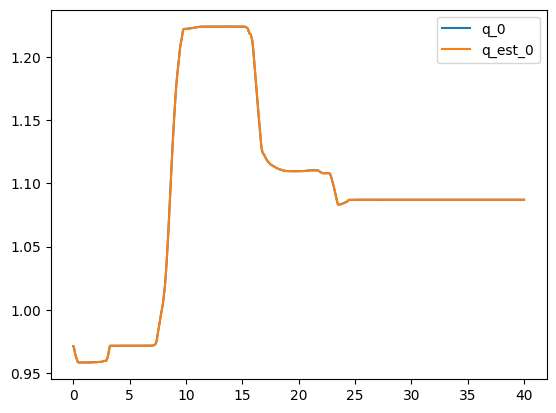

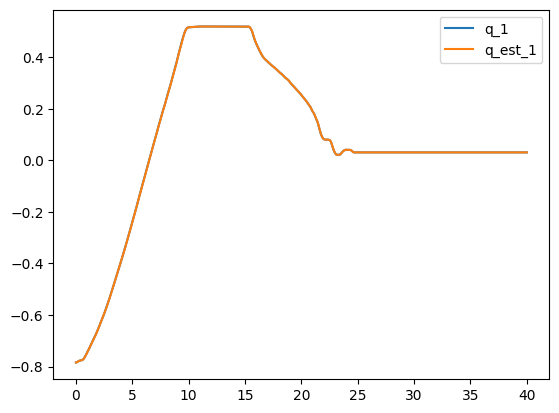

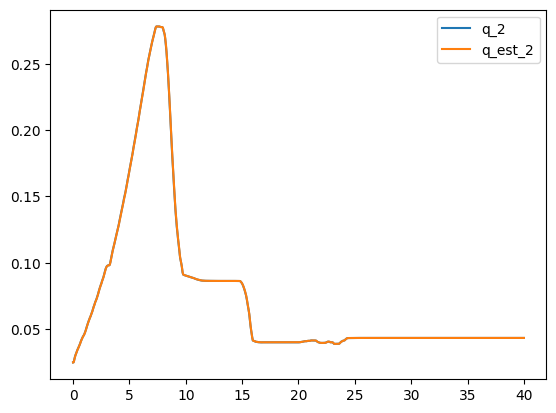

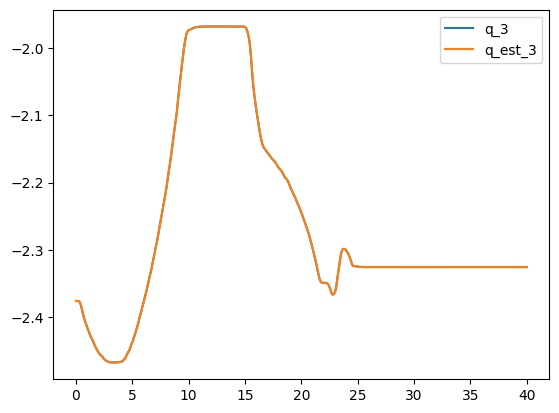

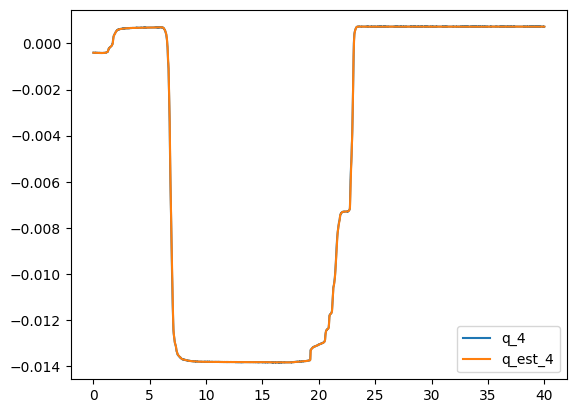

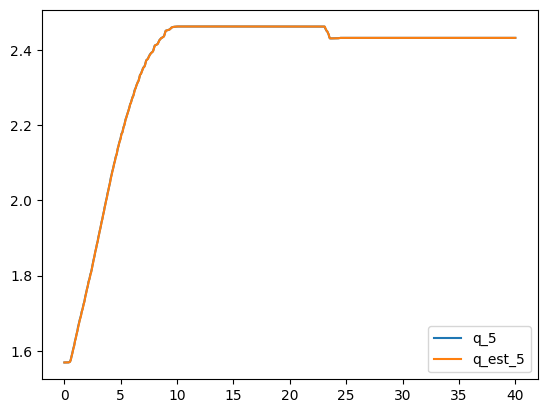

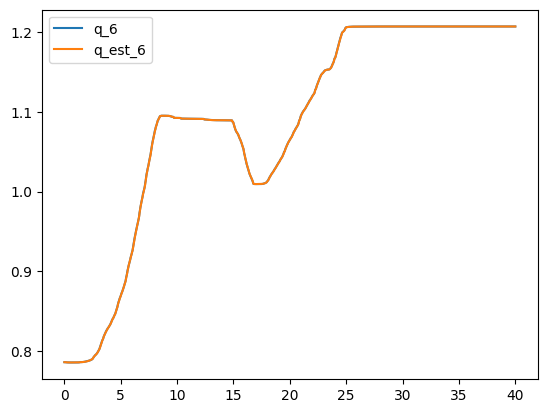

In [12]:
import matplotlib.pyplot as plt

t_list = np.array(t_list)
q_list = np.array(q_list)
q_moving_avg_list = np.array(q_moving_avg_list)


for i in range(7):
    plt.figure(i)
    plt.plot(t_list, q_list[:,i], label='q_{:d}'.format(i))
    plt.plot(t_list, q_moving_avg_list[:,i], label='q_est_{:d}'.format(i))
    plt.legend()

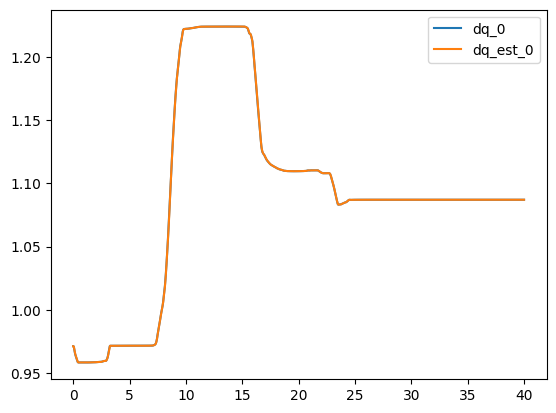

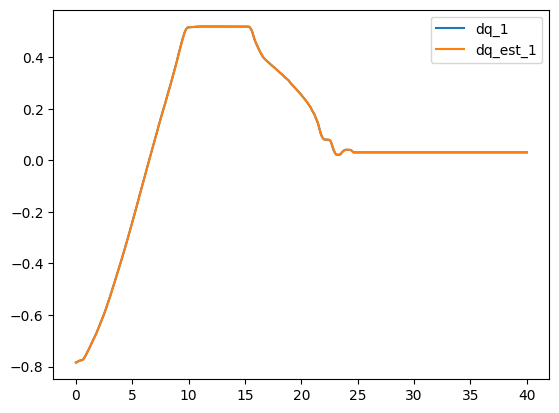

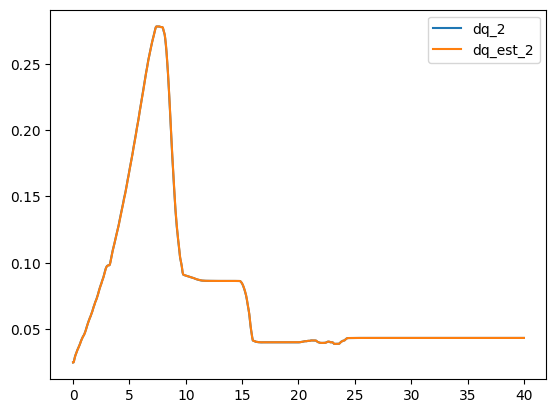

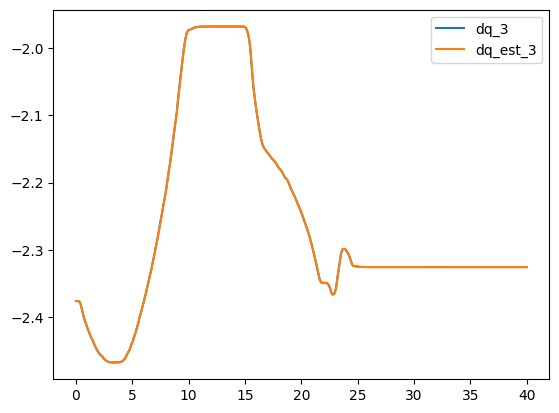

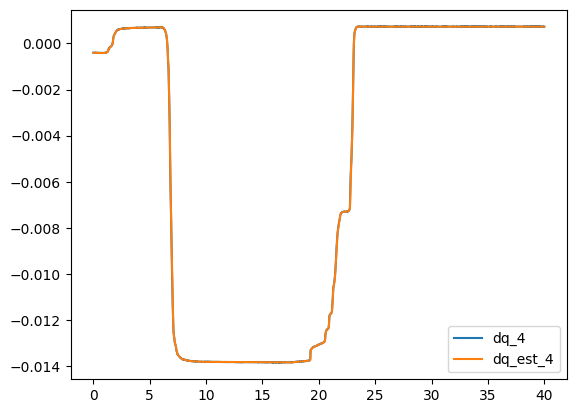

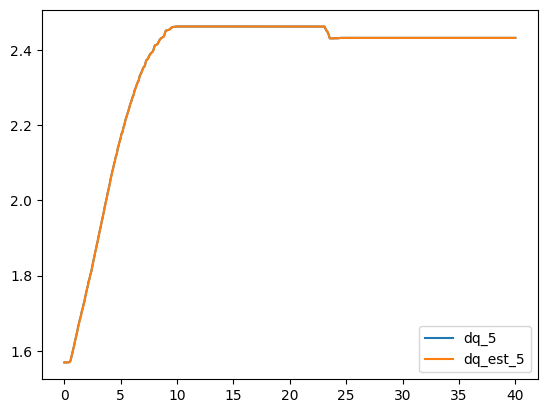

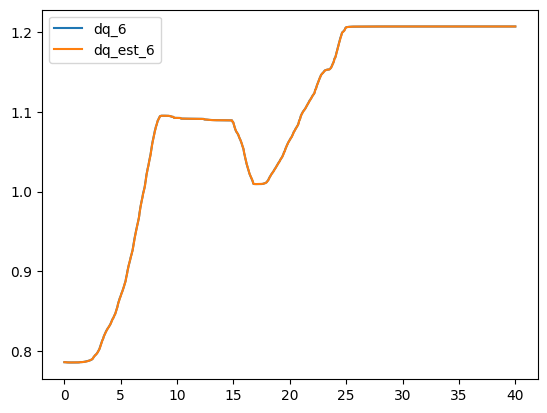

In [13]:
import matplotlib.pyplot as plt

t_list = np.array(t_list)
dq_list = np.array(q_list)
dq_moving_avg_list = np.array(q_moving_avg_list)


for i in range(7):
    plt.figure(i)
    plt.plot(t_list, dq_list[:,i], label='dq_{:d}'.format(i))
    plt.plot(t_list, dq_moving_avg_list[:,i], label='dq_est_{:d}'.format(i))
    plt.legend()

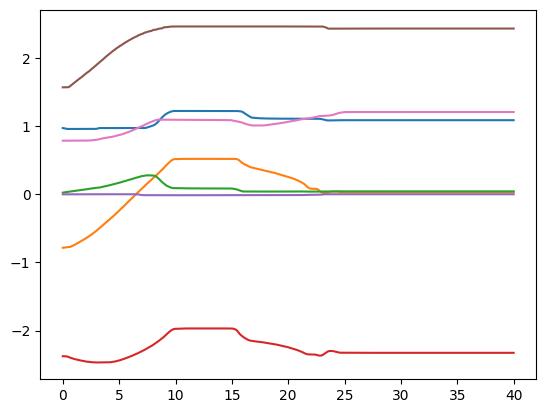

In [14]:
dq_list = np.array(dq_list)

plt.figure()
# plt.plot(dq_list[:,5])

plt.plot(t_list, dq_list)


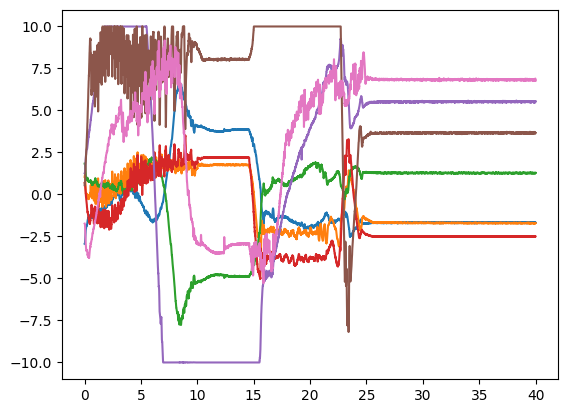

In [15]:
ddq_list = np.array(ddq_list)

plt.figure()
plt.plot(t_list, ddq_list)

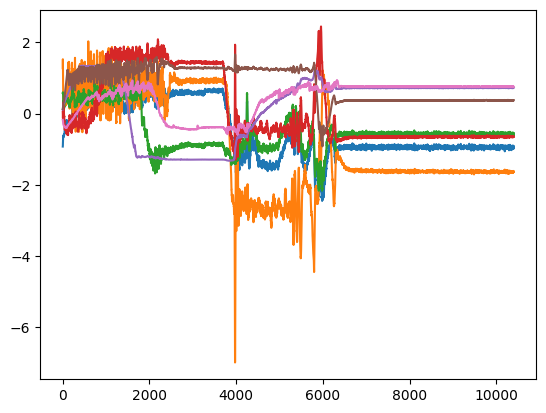

In [16]:
tau_list = np.array(tau_list)
plt.figure()
plt.plot(tau_list)

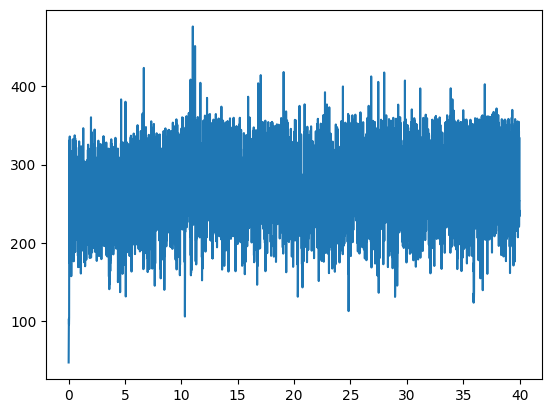

In [17]:
t_list = np.array(t_list)
loop_time_list = np.array(loop_time_list)
plt.figure()
plt.plot(t_list, 1/loop_time_list)

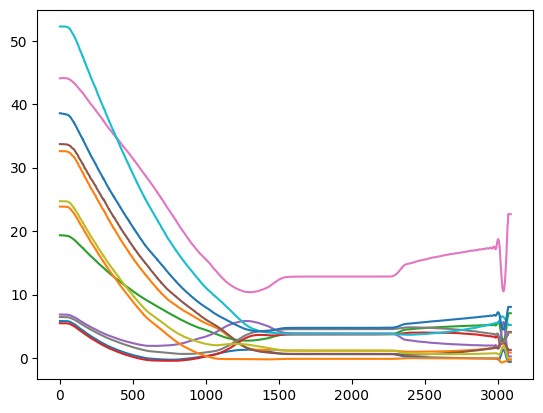

In [203]:
all_h_list = np.array(all_h_list)
plt.figure()
plt.plot(all_h_list)

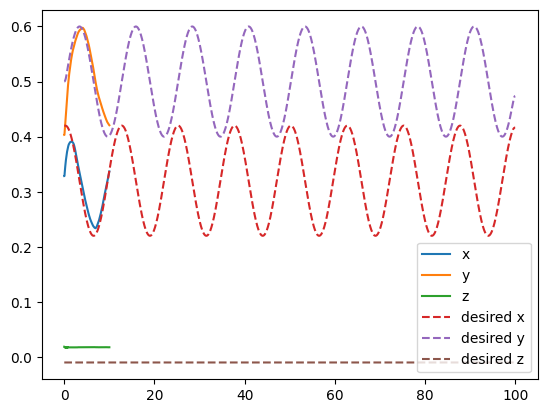

In [67]:
import matplotlib.pyplot as plt

pos_list = np.array(pos_list)
u_nominal_list = np.array(u_nominal_list)
t_list = np.array(t_list)

plt.figure()
plt.plot(t_list, pos_list[:,0], label='x')
plt.plot(t_list, pos_list[:,1], label='y')
plt.plot(t_list, pos_list[:,2], label='z')
plt.plot(traj.t, traj.pd[:,0], '--', label='desired x')
plt.plot(traj.t, traj.pd[:,1], '--', label='desired y')
plt.plot(traj.t, traj.pd[:,2], '--', label='desired z')
plt.legend()



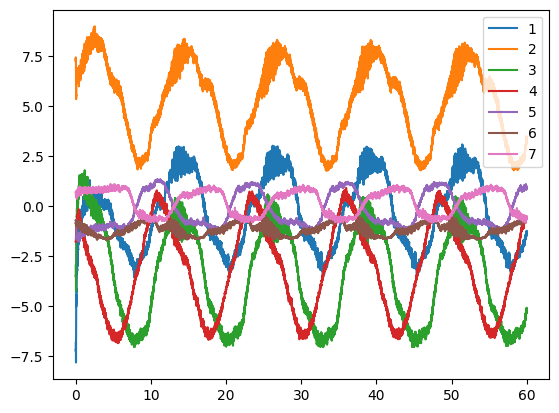

In [10]:

plt.figure()
plt.plot(t_list, u_nominal_list[:,0], label='1')
plt.plot(t_list, u_nominal_list[:,1], label='2')
plt.plot(t_list, u_nominal_list[:,2], label='3')
plt.plot(t_list, u_nominal_list[:,3], label='4')
plt.plot(t_list, u_nominal_list[:,4], label='5')
plt.plot(t_list, u_nominal_list[:,5], label='6')
plt.plot(t_list, u_nominal_list[:,6], label='7')

plt.legend()


### Recover to initial pose

In [55]:
via_points = np.array([P_EE, np.array([P_EE[0], P_EE[1], P_EE[2]+0.2])])
target_time = np.array([0, 5])
traj = TrapezoidalTrajectory(via_points, target_time, T_antp=0.2, Ts=0.01)

In [56]:
T = 7

Kp_task = np.diag([40,40,40,100,100,100])
Kd_task = np.diag([40,40,40,100,100,100])

Kp_joint = np.diag([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])*10
Kd_joint = np.diag([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])*10

delta = 0.1

t_start = time.time()
while time.time() - t_start < T:
    t = time.time() - t_start
    traj_pos, traj_vel, traj_acc = traj.get_traj_and_ders(t)

    q = 0.025*np.ones(9)
    dq = np.zeros(9)
    robot_info = robot.getStates()
    q[0:n_joints] = robot_info['q']
    dq[0:n_joints] = robot_info['dq']

    pin_info = pin_robot.getInfo(q, dq)
    q = q[0:n_joints]
    dq = dq[0:n_joints]
    P_EE = pin_info["P_EE"]
    R_EE = pin_info["R_EE"]
    J_EE = pin_info["J_EE"][:,0:n_joints] # shape (6,7)
    dJdq_EE = pin_info["dJdq_EE"] # shape (6,)
    v_EE = J_EE @ dq # shape (6,)
    M = pin_info["M"][0:n_joints,0:n_joints] + delta*np.eye(n_joints) # shape (7,7)
    # Minv = pin_info["Minv"][0:n_joints,0:n_joints]   # shape (7,7)
    Minv = np.linalg.inv(M)
    nle = pin_info["nle"][0:n_joints]  # shape (7,)
    G = pin_info["G"][0:n_joints]  # shape (7,)

    S, u_task = get_torque_to_track_traj_const_ori(traj_pos, traj_vel, traj_acc, R_EE_desired, Kp_task, Kd_task, Minv, J_EE, dJdq_EE, dq, P_EE, R_EE)

    # Secondary objective: encourage the joints to remain close to the initial configuration
    W = np.diag(1.0/(joint_ub-joint_lb))
    eq = W @ (q - q_bar)
    deq = W @ dq
    u_joint = M @ (- Kd_joint @ deq - Kp_joint @ eq) 

    # Compute the input torque
    Spinv = S.T @ np.linalg.pinv(S @ S.T + 0.01* np.eye(S.shape[0]))
    u_nominal =  Spinv @ u_task + (np.eye(len(q)) - Spinv @ S) @ u_joint
    u = np.clip(u_nominal, -20, 20)
    robot.setCommands(u)

robot.setCommands(np.zeros_like(u))

In [98]:
while True:
    robot_info = robot.getJointStates()
    q = robot_info['q'] # shape (7,)
    dq = robot_info['dq'] # shape (7,)

    q_pin = 0.025*np.ones(9)
    dq_pin = np.zeros(9)
    q_pin[0:n_joints] = q # shape (9,)
    dq_pin[0:n_joints] = dq # shape (9,)

    pin_info = pin_robot.getInfo(q_pin, dq_pin)
    print(pin_info["P_EE"])
    print(pin_info["R_EE"])

[0.51571146 0.03231744 0.02420768]
[[ 0.99962312  0.00770026 -0.02634989]
 [ 0.00777052 -0.99996652  0.00256506]
 [-0.02632926 -0.00276884 -0.99964949]]
[0.51571146 0.03231744 0.02420768]
[[ 0.99962312  0.00770026 -0.02634989]
 [ 0.00777052 -0.99996652  0.00256506]
 [-0.02632926 -0.00276884 -0.99964949]]
[0.51571146 0.03231744 0.02420768]
[[ 0.99962312  0.00770026 -0.02634989]
 [ 0.00777052 -0.99996652  0.00256506]
 [-0.02632926 -0.00276884 -0.99964949]]
[0.51570932 0.03231397 0.0242057 ]
[[ 0.99962307  0.00769373 -0.02635389]
 [ 0.00776397 -0.99996657  0.00256389]
 [-0.02633328 -0.00276754 -0.99964939]]
[0.51570932 0.03231397 0.0242057 ]
[[ 0.99962307  0.00769373 -0.02635389]
 [ 0.00776397 -0.99996657  0.00256389]
 [-0.02633328 -0.00276754 -0.99964939]]
[0.51570932 0.03231397 0.0242057 ]
[[ 0.99962307  0.00769373 -0.02635389]
 [ 0.00776397 -0.99996657  0.00256389]
 [-0.02633328 -0.00276754 -0.99964939]]
[0.51570932 0.03231397 0.0242057 ]
[[ 0.99962307  0.00769373 -0.02635389]
 [ 0.007

KeyboardInterrupt: 